In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [11]:
data_train = pd.read_csv("data/train.csv")

In [12]:
data_train.drop(["id"], axis=1, inplace=True)

data_train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [13]:
data_train.isna().any().value_counts()

False    17
Name: count, dtype: int64

## EDA on Numeric Features

=== Summary Statistics ===
                 age        balance       duration       campaign  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       40.926395    1204.067397     256.229144       2.577008   
std        10.098829    2836.096759     272.555662       2.718514   
min        18.000000   -8019.000000       1.000000       1.000000   
25%        33.000000       0.000000      91.000000       1.000000   
50%        39.000000     634.000000     133.000000       2.000000   
75%        48.000000    1390.000000     361.000000       3.000000   
max        95.000000   99717.000000    4918.000000      63.000000   

               pdays       previous  
count  750000.000000  750000.000000  
mean       22.412733       0.298545  
std        77.319998       1.335926  
min        -1.000000       0.000000  
25%        -1.000000       0.000000  
50%        -1.000000       0.000000  
75%        -1.000000       0.000000  
max       871.000000     200.000000  


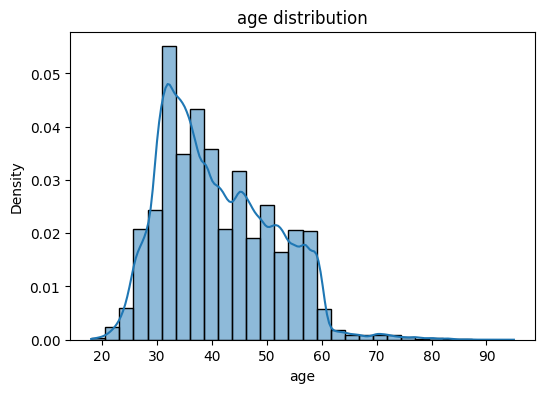

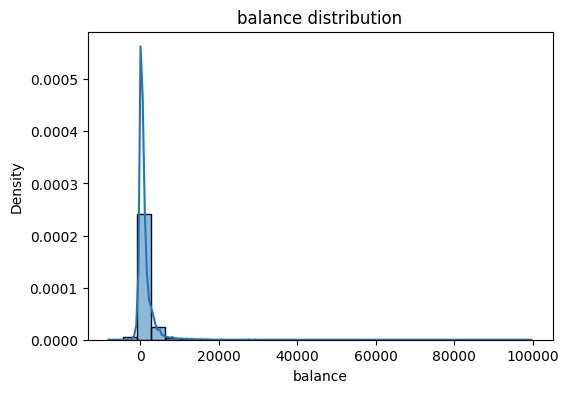

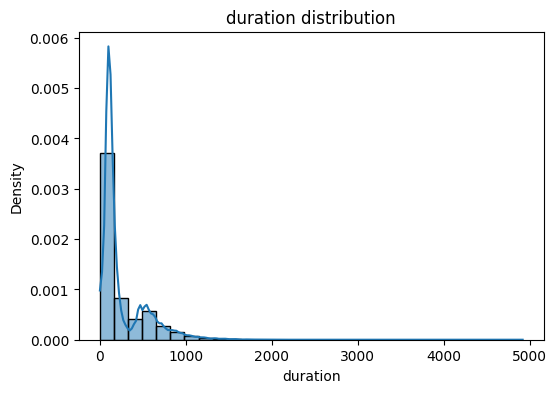

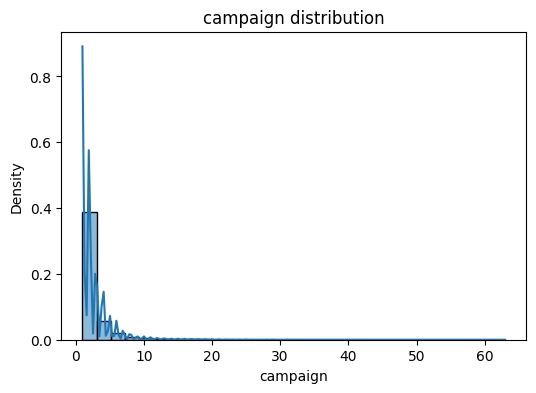

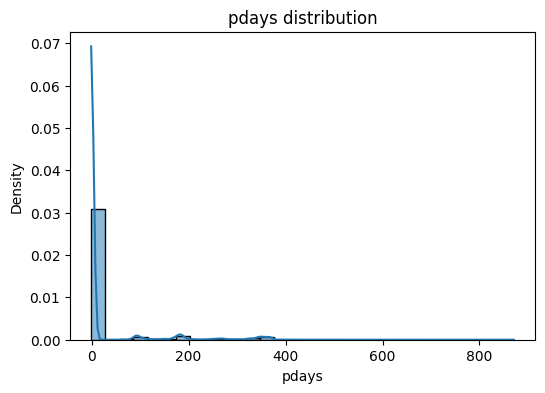

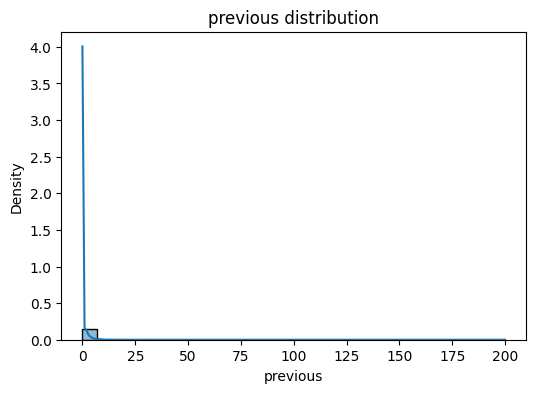

In [14]:

# 1. Specify the numeric columns
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# 2. Summary statistics
print("=== Summary Statistics ===")
print(data_train[num_cols].describe())

# 3. Plot histograms + KDEs
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data_train[col], kde=True, stat="density", bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [15]:

# 4. Outlier detection
outlier_info = {}
for col in num_cols:
    Q1 = data_train[col].quantile(0.25)
    Q3 = data_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    mask_iqr = (data_train[col] < lower) | (data_train[col] > upper)
    pct_iqr = mask_iqr.mean() * 100
    
    z_scores = np.abs(stats.zscore(data_train[col].dropna()))
    mask_z = z_scores > 3
    pct_z = mask_z.mean() * 100
    
    outlier_info[col] = {
        'IQR_bounds': (lower, upper),
        '% outside IQR': pct_iqr,
        '% |z|>3': pct_z
    }

print("\n=== Outlier Summary ===")
for col, info in outlier_info.items():
    print(f"{col:>8}:  IQR outliers ~{info['% outside IQR']:.1f}%  |  Z outliers ~{info['% |z|>3']:.1f}%")




=== Outlier Summary ===
     age:  IQR outliers ~0.7%  |  Z outliers ~0.5%
 balance:  IQR outliers ~7.7%  |  Z outliers ~1.2%
duration:  IQR outliers ~6.1%  |  Z outliers ~1.8%
campaign:  IQR outliers ~5.4%  |  Z outliers ~2.0%
   pdays:  IQR outliers ~10.3%  |  Z outliers ~4.1%
previous:  IQR outliers ~10.3%  |  Z outliers ~1.6%


In [19]:
# Handling skew / outliers

# Log-transform (for right-skew)
data_train['balance_log'] = np.log1p(data_train['balance'])
data_train.drop(['balance'], axis=1, inplace=True)


/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
data_train['pdays_never'] = (data_train['pdays'] == 999).astype(int)
#    — now 1 means “never contacted”, 0 means “was contacted at least once”

# 2. Clean up pdays for those who were contacted
#    Replace 999 with NaN so that any continuous transform (log, scaling) ignores the “never” cases
data_train['pdays_clean'] = data_train['pdays'].replace(999, np.nan)

#    If you want to keep a numeric feature for “days since last contact”:
#    e.g. log-transform it (skips the NaNs automatically)
data_train['pdays_log'] = np.log1p(data_train['pdays_clean'])

# 3. (Optional) Bucket the contacted‐at‐least‐once values into coarse categories
bins   = [0, 5, 15, 30, 60, np.inf]
labels = ['0–5d', '6–15d', '16–30d', '31–60d', '60+d']
data_train['pdays_bucket'] = pd.cut(data_train['pdays_clean'], bins=bins, labels=labels)

#    Then one-hot encode if you like:
data_train = pd.get_dummies(data_train, columns=['pdays_bucket'], drop_first=True)

# 4. Drop or archive the raw pdays if you no longer need it
data_train.drop(columns=['pdays'], inplace=True)

# ——— sanity check ———
data_train.head()

/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,age,job,marital,education,default,balance,housing,loan,contact,day,...,poutcome,y,balance_log,pdays_never,pdays_clean,pdays_log,pdays_bucket_6–15d,pdays_bucket_16–30d,pdays_bucket_31–60d,pdays_bucket_60+d
0,42,technician,married,secondary,no,7,no,no,cellular,25,...,unknown,0,2.079442,0,-1,-inf,False,False,False,False
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,...,unknown,0,6.244167,0,-1,-inf,False,False,False,False
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,...,unknown,0,6.401917,0,-1,-inf,False,False,False,False
3,27,student,single,secondary,no,34,yes,no,unknown,28,...,unknown,0,3.555348,0,-1,-inf,False,False,False,False
4,26,technician,married,secondary,no,889,yes,no,cellular,3,...,unknown,1,6.791221,0,-1,-inf,False,False,False,False


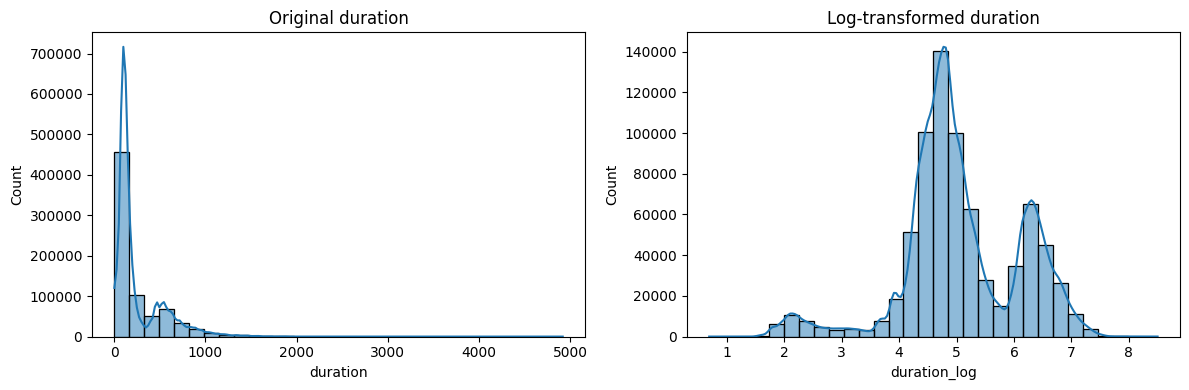

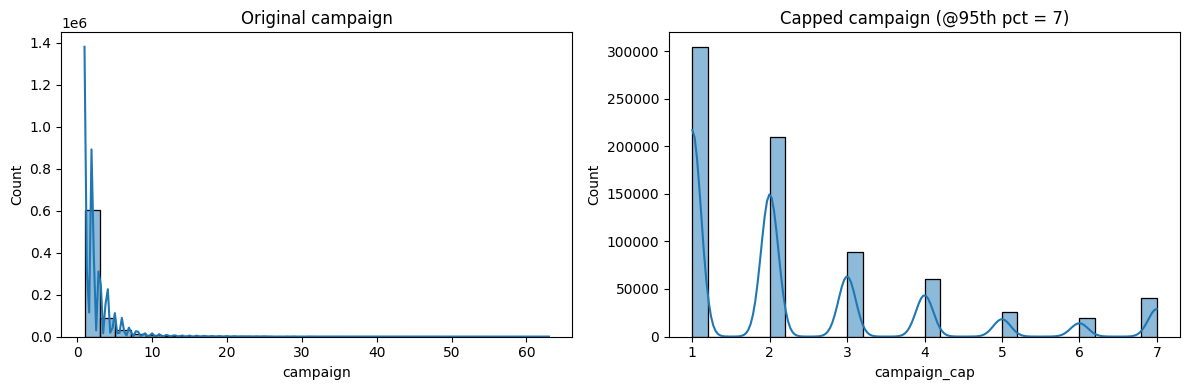

In [21]:
data_train['duration_log'] = np.log1p(data_train['duration'])

# (Optional) Quick before/after plot for 'duration'
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data_train['duration'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Original duration")
sns.histplot(data_train['duration_log'], kde=True, ax=axes[1], bins=30)
axes[1].set_title("Log-transformed duration")
plt.tight_layout()
plt.show()

# 2. Cap the 'campaign' column at its 95th percentile
cap_95 = data_train['campaign'].quantile(0.95)
data_train['campaign_cap'] = data_train['campaign'].clip(upper=cap_95)

# (Optional) Compare campaign distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data_train['campaign'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Original campaign")
sns.histplot(data_train['campaign_cap'], kde=True, ax=axes[1], bins=30)
axes[1].set_title(f"Capped campaign (@95th pct = {cap_95:.0f})")
plt.tight_layout()
plt.show()

In [22]:
data_train.drop(columns=['campaign', 'duration'], axis = 1, inplace=True)

In [23]:
cap_val = 5
data_train['previous_cap'] = data_train['previous'].clip(upper=cap_val)

# 2. Bucket into (0), (1–3), (4+)
bins  = [-1, 0, 3, np.inf]      # note: -1 so that 0 goes in the first bin
labels = ['0', '1-3', '4+']
data_train['previous_bucket'] = pd.cut(data_train['previous'], bins=bins, labels=labels)

# 3. (Optional) One-hot encode the buckets
data_train = pd.get_dummies(data_train, columns=['previous_bucket'], prefix='prev', drop_first=False)

# 4. Drop the original column
data_train.drop(columns=['previous'], inplace=True)

In [25]:
data_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'day', 'month', 'poutcome', 'y', 'balance_log',
       'pdays_never', 'pdays_clean', 'pdays_log', 'pdays_bucket_6–15d',
       'pdays_bucket_16–30d', 'pdays_bucket_31–60d', 'pdays_bucket_60+d',
       'duration_log', 'campaign_cap', 'previous_cap', 'prev_0', 'prev_1-3',
       'prev_4+'],
      dtype='object')